In [71]:
import os

import matplotlib.pyplot as plt

from pydrake.geometry import StartMeshcat
from pydrake.multibody import inverse_kinematics
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.scenarios import AddIiwaDifferentialIK, ExtractBodyPose, MakeManipulationStation
from manipulation.meshcat_utils import AddMeshcatTriad, PublishPositionTrajectory
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    FixedOffsetFrame,
    InverseDynamicsController,
    InverseKinematics,
    JacobianWrtVariable,
    ModelInstanceIndex,
    MultibodyPlant,
    RotationMatrix,
    Simulator,
    Solve,
    Trajectory,
    TrajectorySource,
    KinematicTrajectoryOptimization,
    BsplineTrajectory,
    PositionConstraint,
    OrientationConstraint,
    MinimumDistanceLowerBoundConstraint,

    # cloned from MakeManipulationStation
    AbstractValue,
    Adder,
    AddMultibodyPlantSceneGraph,
    BallRpyJoint,
    BaseField,
    Box,
    CameraInfo,
    Capsule,
    ClippingRange,
    CoulombFriction,
    Cylinder,
    Demultiplexer,
    DepthImageToPointCloud,
    DepthRange,
    DepthRenderCamera,
    DiagramBuilder,
    DifferentialInverseKinematicsIntegrator,
    DifferentialInverseKinematicsParameters,
    GeometryInstance,
    InverseDynamicsController,
    LeafSystem,
    MakeMultibodyStateToWsgStateSystem,
    MakePhongIllustrationProperties,
    MakeRenderEngineVtk,
    ModelInstanceIndex,
    MultibodyPlant,
    Parser,
    PassThrough,
    PrismaticJoint,
    RenderCameraCore,
    RenderEngineVtkParams,
    RevoluteJoint,
    Rgba,
    RgbdSensor,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    SchunkWsgPositionController,
    SpatialInertia,
    Sphere,
    StateInterpolatorWithDiscreteDerivative,
    UnitInertia,
)
from pydrake.visualization import MeshcatPoseSliders
from manipulation.meshcat_utils import WsgButton
from manipulation.utils import ConfigureParser


from utils import *

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [96]:
def AddRgbdSensor(
    builder,
    plant,
    scene_graph,
    parent_idx,
    transform,
    name
):
  
    renderer = "my_renderer"
    if not scene_graph.HasRenderer(renderer):
        scene_graph.AddRenderer(
            renderer, MakeRenderEngineVtk(RenderEngineVtkParams())
        )

    depth_camera = DepthRenderCamera(
        RenderCameraCore(
            renderer,
            CameraInfo(width=480, height=480, fov_y=np.pi / 4.0),
            ClippingRange(near=0.005, far=10.0),
            RigidTransform(),
        ),
        DepthRange(0.005, 10.0),
    )

    rgbd = builder.AddSystem(
        RgbdSensor(
            parent_id=plant.GetBodyFrameIdOrThrow(parent_idx),
            X_PB=transform,
            depth_camera=depth_camera,
            show_window=False,
        )
    )
    rgbd.set_name(name)

    builder.Connect(
        scene_graph.get_query_output_port(),
        rgbd.query_object_input_port(),
    )

    # Export the camera outputs
    builder.ExportOutput(
        rgbd.color_image_output_port(), f"{name}_rgb_image"
    )
    builder.ExportOutput(
        rgbd.depth_image_32F_output_port(), f"{name}_depth_image"
    )
    builder.ExportOutput(
        rgbd.label_image_output_port(), f"{name}_label_image"
    )

    # Add a system to convert the camera output into a point cloud
    to_point_cloud = builder.AddSystem(
        DepthImageToPointCloud(
            camera_info=rgbd.depth_camera_info(),
            fields=BaseField.kXYZs | BaseField.kRGBs,
        )
    )
    builder.Connect(
        rgbd.depth_image_32F_output_port(),
        to_point_cloud.depth_image_input_port(),
    )
    builder.Connect(
        rgbd.color_image_output_port(),
        to_point_cloud.color_image_input_port(),
    )
    camera_pose = builder.AddSystem(
        ExtractBodyPose(
            plant.get_body_poses_output_port(), parent_idx
        )
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        camera_pose.get_input_port(),
    )
    builder.Connect(
        camera_pose.get_output_port(),
        to_point_cloud.GetInputPort("camera_pose"),
    )
    # Export the point cloud output.
    builder.ExportOutput(
        to_point_cloud.point_cloud_output_port(),
        f"{name}_point_cloud",
    )


In [97]:
def AddIiwa(plant, collision_model="no_collision"):
    parser = Parser(plant)
    iiwa = parser.AddModelsFromUrl(
        f"package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_{collision_model}.sdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))

    # Set default positions:
    q0 = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1

    return iiwa

def AddWsg(
    plant, iiwa_model_instance, roll=np.pi / 2.0, welded=False, sphere=False
):
    parser = Parser(plant)
    ConfigureParser(parser)
    if welded:
        if sphere:
            file = "package://manipulation/schunk_wsg_50_welded_fingers_sphere.sdf"
        else:
            file = "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    else:
        file = "package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf"

    directives = f"""
directives:
- add_model:
    name: gripper
    file: {file}
"""
    gripper = parser.AddModelsFromString(directives, ".dmd.yaml")[0]

    X_7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, roll), [0, 0, 0.09])
    plant.WeldFrames(
        plant.GetFrameByName("iiwa_link_7", iiwa_model_instance),
        plant.GetFrameByName("body", gripper),
        X_7G,
    )
    return gripper


def MakeManipulationStation(
    model_directives=None,
    filename=None,
    time_step=0.002,
    iiwa_prefix="iiwa",
    wsg_prefix="wsg",
    camera_prefix="camera",
    prefinalize_callback=None,
    package_xmls=[],
):
    """
    Creates a manipulation station system, which is a sub-diagram containing:
      - A MultibodyPlant with populated via the Parser from the
        `model_directives` argument AND the `filename` argument.
      - A SceneGraph
      - For each model instance starting with `iiwa_prefix`, we add an
        additional iiwa controller system
      - For each model instance starting with `wsg_prefix`, we add an
        additional schunk controller system
      - For each body starting with `camera_prefix`, we add a RgbdSensor

    Args:
        builder: a DiagramBuilder

        model_directives: a string containing any model directives to be parsed

        filename: a string containing the name of an sdf, urdf, mujoco xml, or
        model directives yaml file.

        time_step: the standard MultibodyPlant time step.

        iiwa_prefix: Any model instances starting with `iiwa_prefix` will get
        an inverse dynamics controller, etc attached

        wsg_prefix: Any model instance starting with `wsg_prefix` will get a
        schunk controller

        camera_prefix: Any bodies in the plant (created during the
        plant_setup_callback) starting with this prefix will get a camera
        attached.

        prefinalize_callback: A function, setup(plant), that will be called
        with the multibody plant before calling finalize.  This can be useful
        for e.g. adding additional bodies/models to the simulation.

        package_xmls: A list of filenames to be passed to
        PackageMap.AddPackageXml().  This is useful if you need to add more
        models to your path (e.g. from your current working directory).
    """
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=time_step
    )
    parser = Parser(plant)
    for p in package_xmls:
        parser.package_map().AddPackageXml(p)
    ConfigureParser(parser)
    if model_directives:
        parser.AddModelsFromString(model_directives, ".dmd.yaml")
    if filename:
        parser.AddModelsFromUrl(filename)
    if prefinalize_callback:
        prefinalize_callback(plant)
    plant.Finalize()

    for i in range(plant.num_model_instances()):
        model_instance = ModelInstanceIndex(i)
        model_instance_name = plant.GetModelInstanceName(model_instance)

        if model_instance_name.startswith(iiwa_prefix):
            num_iiwa_positions = plant.num_positions(model_instance)

            # I need a PassThrough system so that I can export the input port.
            iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
            builder.ExportInput(
                iiwa_position.get_input_port(),
                model_instance_name + "_position",
            )
            builder.ExportOutput(
                iiwa_position.get_output_port(),
                model_instance_name + "_position_commanded",
            )

            # Export the iiwa "state" outputs.
            demux = builder.AddSystem(
                Demultiplexer(2 * num_iiwa_positions, num_iiwa_positions)
            )
            builder.Connect(
                plant.get_state_output_port(model_instance),
                demux.get_input_port(),
            )
            builder.ExportOutput(
                demux.get_output_port(0),
                model_instance_name + "_position_measured",
            )
            builder.ExportOutput(
                demux.get_output_port(1),
                model_instance_name + "_velocity_estimated",
            )
            builder.ExportOutput(
                plant.get_state_output_port(model_instance),
                model_instance_name + "_state_estimated",
            )

            # Make the plant for the iiwa controller to use.
            controller_plant = MultibodyPlant(time_step=time_step)
            # TODO: Add the correct IIWA model (introspected from MBP)
            if plant.num_positions(model_instance) == 3:
                controller_iiwa = AddPlanarIiwa(controller_plant)
            else:
                controller_iiwa = AddIiwa(controller_plant)
            AddWsg(controller_plant, controller_iiwa, welded=True)
            controller_plant.Finalize()

            # Add the iiwa controller
            kp = 100
            iiwa_controller = builder.AddSystem(
                InverseDynamicsController(
                    controller_plant,
                    kp=[kp] * num_iiwa_positions,
                    ki=[1] * num_iiwa_positions,
                    kd=[20] * num_iiwa_positions,
                    has_reference_acceleration=False,
                )
            )
            print(f"kp: {kp}")
            iiwa_controller.set_name(model_instance_name + "_controller")
            builder.Connect(
                plant.get_state_output_port(model_instance),
                iiwa_controller.get_input_port_estimated_state(),
            )

            # Add in the feed-forward torque
            adder = builder.AddSystem(Adder(2, num_iiwa_positions))
            builder.Connect(
                iiwa_controller.get_output_port_control(),
                adder.get_input_port(0),
            )
            # Use a PassThrough to make the port optional (it will provide zero
            # values if not connected).
            torque_passthrough = builder.AddSystem(
                PassThrough([0] * num_iiwa_positions)
            )
            builder.Connect(
                torque_passthrough.get_output_port(), adder.get_input_port(1)
            )
            builder.ExportInput(
                torque_passthrough.get_input_port(),
                model_instance_name + "_feedforward_torque",
            )
            builder.Connect(
                adder.get_output_port(),
                plant.get_actuation_input_port(model_instance),
            )

            # Add discrete derivative to command velocities.
            desired_state_from_position = builder.AddSystem(
                StateInterpolatorWithDiscreteDerivative(
                    num_iiwa_positions,
                    time_step,
                    suppress_initial_transient=True,
                )
            )
            desired_state_from_position.set_name(
                model_instance_name + "_desired_state_from_position"
            )
            builder.Connect(
                desired_state_from_position.get_output_port(),
                iiwa_controller.get_input_port_desired_state(),
            )
            builder.Connect(
                iiwa_position.get_output_port(),
                desired_state_from_position.get_input_port(),
            )

            # Export commanded torques.
            builder.ExportOutput(
                adder.get_output_port(),
                model_instance_name + "_torque_commanded",
            )
            builder.ExportOutput(
                adder.get_output_port(),
                model_instance_name + "_torque_measured",
            )

            builder.ExportOutput(
                plant.get_generalized_contact_forces_output_port(
                    model_instance
                ),
                model_instance_name + "_torque_external",
            )

        elif model_instance_name.startswith(wsg_prefix):
            # Wsg controller.
            wsg_controller = builder.AddSystem(SchunkWsgPositionController())
            wsg_controller.set_name(model_instance_name + "_controller")
            builder.Connect(
                wsg_controller.get_generalized_force_output_port(),
                plant.get_actuation_input_port(model_instance),
            )
            builder.Connect(
                plant.get_state_output_port(model_instance),
                wsg_controller.get_state_input_port(),
            )
            builder.ExportInput(
                wsg_controller.get_desired_position_input_port(),
                model_instance_name + "_position",
            )
            builder.ExportInput(
                wsg_controller.get_force_limit_input_port(),
                model_instance_name + "_force_limit",
            )
            wsg_mbp_state_to_wsg_state = builder.AddSystem(
                MakeMultibodyStateToWsgStateSystem()
            )
            builder.Connect(
                plant.get_state_output_port(model_instance),
                wsg_mbp_state_to_wsg_state.get_input_port(),
            )
            builder.ExportOutput(
                wsg_mbp_state_to_wsg_state.get_output_port(),
                model_instance_name + "_state_measured",
            )
            builder.ExportOutput(
                wsg_controller.get_grip_force_output_port(),
                model_instance_name + "_force_measured",
            )

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "query_object")
    builder.ExportOutput(
        plant.get_contact_results_output_port(), "contact_results"
    )
    builder.ExportOutput(
        plant.get_state_output_port(), "plant_continuous_state"
    )
    builder.ExportOutput(plant.get_body_poses_output_port(), "body_poses")

    return builder, plant, scene_graph

In [98]:
# Visualize Apple Tree

meshcat.Delete()

iiwa_x, iiwa_y, iiwa_z = [-0, 1.1, 0.3]
iiwa_R, iiwa_P, iiwa_Y = [0, 0, -10]
q_default = np.array([0.21396261, 1.61186971,-1.34264572,-1.2,-1.55039915, 1.91103543,-1.65827279])


# Visualize the apple tree
visualize_model(meshcat)

kp: 100


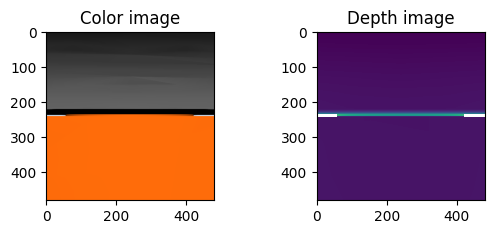

In [107]:
# Build the environment

meshcat.Delete()

# Load scenario data
scenario_data = make_scenario_data(tree_model_name, iiwa_R, iiwa_P, iiwa_Y, iiwa_x, iiwa_y, iiwa_z, q_default)

builder = DiagramBuilder()

manipulation_station_builder, manipulation_station_plant, manipulation_station_scene_graph = MakeManipulationStation(model_directives=scenario_data, time_step=0.005)


# Add all our RGBD sensors
camera_link_transforms = {
    1 : RigidTransform([0, -0.04, 0.11]),
    2 : RigidTransform([0, 0.11, 0.05]),
    3 : RigidTransform([0, 0.03, 0.12]),
    4 : RigidTransform([0, 0.1, 0.04]),
    5 : RigidTransform([0, 0, 0.1]), # todo - this is a weirdly shaped link - could need two cameras
    6 : RigidTransform([0, 0, 0.04]),
}

camera_orientations = {
    0 : RigidTransform(RotationMatrix.MakeXRotation(0), [0, 0, 0]),
    #1 : RigidTransform(RotationMatrix.MakeXRotation(np.pi/2), [0, 0, 0]),
    #2 : RigidTransform(RotationMatrix.MakeXRotation(np.pi), [0, 0, 0]),
    #3 : RigidTransform(RotationMatrix.MakeXRotation(3 * np.pi/2), [0, 0, 0]),
    #4 : RigidTransform(RotationMatrix.MakeYRotation(np.pi/2), [0, 0, 0]),
    #5 : RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), [0, 0, 0]),
}


for i in range(8):
    if not i in camera_link_transforms.keys():
        continue

    link_body = manipulation_station_plant.GetBodyByName(f"iiwa_link_{i}")
    camera_transform = camera_link_transforms[i]

    for orientation_idx in camera_orientations:
        orientation = camera_orientations[orientation_idx]
        AddRgbdSensor(manipulation_station_builder, 
                      manipulation_station_plant, 
                      manipulation_station_scene_graph, 
                      link_body.index(), camera_transform @ orientation, f"camera_{i}_{orientation_idx}")



manipulation_station_diagram = manipulation_station_builder.Build()
manipulation_station_diagram.set_name("ManipulationStation")
station = builder.AddSystem(manipulation_station_diagram)


visualizer = MeshcatVisualizer.AddToBuilder(
    builder,
    station.GetOutputPort("query_object"),
    meshcat,
    MeshcatVisualizerParams(delete_on_initialization_event=False),
)


initial_run = 5

initial_trajectory = PiecewisePolynomial.FirstOrderHold([0., initial_run], np.array([q_default, q_default]).T)
q_traj_system = builder.AddSystem(TrajectorySource(initial_trajectory))
builder.Connect(
    q_traj_system.get_output_port(), station.GetInputPort("iiwa_position")
)
initial_g_traj = PiecewisePolynomial.ZeroOrderHold([0., initial_run], np.array([[0.1], [0.1]]).T)
g_traj_system = builder.AddSystem(TrajectorySource(initial_g_traj))
builder.Connect(
    g_traj_system.get_output_port(), station.GetInputPort("wsg_position")
)



diagram = builder.Build()

plant = station.GetSubsystemByName("plant")
diagram_context = diagram.CreateDefaultContext()
station_context = station.GetMyContextFromRoot(diagram_context)
plant_context = plant.GetMyContextFromRoot(diagram_context)

simulator = Simulator(diagram, diagram_context)
#simulator.AdvanceTo(10)

port = station.GetInputPort("iiwa_position")
port.Eval(station_context)

q_traj_system_context = q_traj_system.GetMyContextFromRoot(diagram_context)

meshcat.StartRecording()
simulator.AdvanceTo(initial_run)
meshcat.PublishRecording()

#port = q_traj_system.GetOutputPort("y0")
#print(port.Eval(q_traj_system_context))

iiwa_model = plant.GetModelInstanceByName("iiwa")
q0 = plant.GetPositions(plant_context, iiwa_model)

def get_apple_body_names():
    tree_index = plant.GetModelInstanceByName(tree_model_name)
    apple_body_names = []
    for i in plant.GetBodyIndices(tree_index):
        body_name = plant.get_body(i).name()
        if body_name.startswith('apple_'):
            apple_body_names.append(body_name)
    return apple_body_names

name = ""

def find_closest_apples_to_iiwa():
    iiwa_body = plant.GetBodyByName("left_finger")
    X_WI = plant.EvalBodyPoseInWorld(plant_context, iiwa_body)

    apple_body_names = get_apple_body_names()
    min_distance = np.inf
    apples = []
    for apple_body_name in apple_body_names:
        apple_body = plant.GetBodyByName(apple_body_name)
        X_WA = plant.EvalBodyPoseInWorld(plant_context, apple_body)
        X_IA = X_WI.inverse() @ X_WA
        distance = np.linalg.norm(X_IA.translation())
        apples.append((apple_body_name, X_IA, distance))
        '''
        if distance < min_distance:
            min_distance = distance
            best_apple = apple_body
            name = apple_body_name
    return best_apple
        '''
    apples = sorted(apples, key=lambda apple: apple[2])
    return apples

#best_apple_name = apples[1][0]
#best_apple_body = plant.GetBodyByName(best_apple_name)

#X_WA = plant.EvalBodyPoseInWorld(plant_context, best_apple_body)

#AddMeshcatTriad(meshcat, "apple", length=0.25, radius=0.01, X_PT=X_WA)
#iiwa_body = plant.GetBodyByName("left_finger")
#X_WI = plant.EvalBodyPoseInWorld(plant_context, iiwa_body)



color_image = station.GetOutputPort("camera_1_0_rgb_image").Eval(station_context)
depth_image = station.GetOutputPort("camera_1_0_depth_image").Eval(station_context)
#color_image_1 = station.GetOutputPort("camera_1_1_rgb_image").Eval(station_context)
#depth_image_1 = station.GetOutputPort("camera_1_1_depth_image").Eval(station_context)

# Plot the two images.
plt.subplot(221)
plt.imshow(color_image.data)
plt.title("Color image")
plt.subplot(222)
plt.imshow(np.squeeze(depth_image.data))
plt.title("Depth image")
'''
plt.subplot(223)
plt.imshow(color_image_1.data)
plt.title("Color image")
plt.subplot(224)
plt.imshow(np.squeeze(depth_image_1.data))
plt.title("Depth image")
'''
plt.show()


for i in range(8):
    if not i in camera_link_transforms.keys():
        continue
    
    link_body = plant.GetBodyByName(f"iiwa_link_{i}")
    X_WIL = plant.EvalBodyPoseInWorld(plant_context, link_body)
    camera_transform = camera_link_transforms[i]

    frame = plant.GetFrameByName(f"iiwa_link_{i}")
    for orientation_idx in camera_orientations:
        orientation = camera_orientations[orientation_idx]
    
        #AddMeshcatTriad(meshcat, f"iiwa_link_{i}", length=0.25, radius=0.01, X_PT=X_WIL)
        X_WILA = X_WIL @ camera_transform @ orientation
        AddMeshcatTriad(meshcat, f"iiwa_link_{i}_{orientation_idx}", length=0.25, radius=0.01, X_PT=X_WILA)


In [108]:
def is_pose_feasible(X_WTarget, constrain_orientation, q_home = None, relevant_contacts = None):

    ITERS = 20

    if q_home is None:
        print("using default q_home")
        q_home = q_default

    plant, _, _ = CreateIiwaControllerPlant(q_home, iiwa_R, iiwa_P, iiwa_Y, iiwa_x, iiwa_y, iiwa_z, relevant_contacts=relevant_contacts)
    q_lower_limit = plant.GetPositionLowerLimits()
    q_upper_limit = plant.GetPositionUpperLimits()

    wsg = plant.GetModelInstanceByName("Schunk_Gripper")
    gripper_frame = plant.GetFrameByName("body", wsg)
    world_frame = plant.world_frame()

    q_guess = q_home

    for i in range(ITERS):

        plant_context = plant.CreateDefaultContext()

        ik = InverseKinematics(plant, plant_context)
        ik.AddPositionConstraint(
            gripper_frame,
            [0, 0.1, 0],
            plant.world_frame(),
            X_WTarget.translation(),
            X_WTarget.translation(),
        )
        if constrain_orientation:
            ik.AddOrientationConstraint(
                gripper_frame,
                RotationMatrix(),
                plant.world_frame(),
                X_WTarget.rotation(),
                0,
            )
        prog = ik.get_mutable_prog()
        q = ik.q()
        prog.AddQuadraticErrorCost(np.identity(len(q)), q_home, q)

        K_stiffness = 50
        J_rand = None
        if relevant_contacts is not None:
            for contact in relevant_contacts:
                body_on_iiwa_name, body_on_tree_name, _, force = contact
                #if np.linalg.norm(force) < 1:
                #    print("don't care")
                #    continue
                contact_frame_name = f"contact_{body_on_iiwa_name}_{body_on_tree_name}"
                contact_frame = plant.GetFrameByName(contact_frame_name)
                J = plant.CalcJacobianTranslationalVelocity(
                        plant_context,
                        JacobianWrtVariable.kQDot,
                        contact_frame,
                        [0, 0, 0],
                        world_frame,
                        contact_frame
                    )
                contact_delta = J @ (q - q_home)
                contact_delta = contact_delta[2] * K_stiffness
                J_rand = J
                #print(f"{contact_frame_name}: {contact_delta}")
                prog.AddCost(contact_delta * contact_delta)
                #K_J_sum += (J @ q)[2]

        #print(K_J_sum)
    
        
        prog.SetInitialGuess(q, q_guess)

        
        
        result = Solve(ik.prog())
        if result.is_success():
            #print(f"\tFound feasible end q in {i} iterations without collisions")
            if J_rand is not None:
                cost = (J @ (result.GetSolution() - q_home))[2] * K_stiffness
                cost = cost*cost
                #print(f"Force difference: {cost}")            
                #print(f"Optimal cost: {result.get_optimal_cost()}")
            return True, result.GetSolution()

        print("Trying again")
        q_guess = np.random.uniform(q_lower_limit, q_upper_limit)

    print(f"\tFailed to fine feasible end q without collisions")
    return False, result.GetSolution()

def is_pose_feasible_collisions(X_WTarget, constrain_orientation, q_home = None):

    ITERS = 20

    if q_home is None:
        print("using default q_home")
        q_home = q_default

    plant, diagram, _, _, _ = CreateIiwaControllerPlantCollisions(q_home, iiwa_R, iiwa_P, iiwa_Y, iiwa_x, iiwa_y, iiwa_z)
    q_lower_limit = plant.GetPositionLowerLimits()
    q_upper_limit = plant.GetPositionUpperLimits()
    q_upper_limit[np.where(q_upper_limit == np.inf)] = 0
    q_lower_limit[np.where(q_lower_limit == -np.inf)] = 0
    
    num_q = plant.num_positions()
    iiwa_idx = plant.GetModelInstanceByName(iiwa_name)
    num_q_iiwa = plant.num_positions(iiwa_idx)
    wsg = plant.GetModelInstanceByName(wsg_name)
    gripper_frame = plant.GetFrameByName("body", wsg)

    q_guess = q_home
    q_guess_plant = np.zeros(num_q)
    plant.SetPositionsInArray(iiwa_idx, q_guess, q_guess_plant)

    for i in range(ITERS):

        diagram_context = diagram.CreateDefaultContext()
        plant_context = plant.GetMyContextFromRoot(diagram_context)

        ik = InverseKinematics(plant, plant_context)
        ik.AddPositionConstraint(
            gripper_frame,
            [0, 0.1, 0],
            plant.world_frame(),
            X_WTarget.translation(),
            X_WTarget.translation(),
        )
        if constrain_orientation:
            ik.AddOrientationConstraint(
                gripper_frame,
                RotationMatrix(),
                plant.world_frame(),
                X_WTarget.rotation(),
                0,
            )

        # Collisions
        ik.AddMinimumDistanceLowerBoundConstraint(0.001)
        prog = ik.get_mutable_prog()
        q = ik.q()

        indicator = np.zeros(num_q)
        indicator_iiwa = np.ones(num_q_iiwa)
        plant.SetPositionsInArray(iiwa_idx, indicator_iiwa, indicator)
        indicator = indicator == 0
        Cost_Q = np.eye(num_q)
        Cost_Q[indicator, :] = 0
        prog.AddQuadraticErrorCost(Cost_Q, q_home, q)

        prog.SetInitialGuess(q, q_guess_plant)

        result = Solve(ik.prog())
        if result.is_success():
            print(f"\tFound feasible end q in {i} iterations with collisions")
            return True, result.GetSolution()

        q_guess_plant = np.random.uniform(q_lower_limit, q_upper_limit)
        q_guess_plant[indicator] = 0

    print(f"\tFailed to fine feasible end q with collisions")
    return False, None



In [109]:
def find_trajectory_no_collisions(q_start, X_WTarget, constrain_orientation = True, q_home = None, control_points = 10):

    if q_home is None:
        q_home = q_default

    feasible, q_end = is_pose_feasible(X_WTarget, constrain_orientation, q_home)
    if not feasible:
        return False, None

    visualize = False

    print(q_home)
    local_plant, visualizer, diagram = CreateIiwaControllerPlant(q_home, iiwa_R, iiwa_P, iiwa_Y, iiwa_x, iiwa_y, iiwa_z)

    context = diagram.CreateDefaultContext()
    local_plant_context = local_plant.GetMyContextFromRoot(context)

    world_frame = local_plant.world_frame()

    wsg = local_plant.GetModelInstanceByName("Schunk_Gripper")

    num_q = local_plant.num_positions()
    #q0 = local_plant.GetPositions(local_plant_context)
    gripper_frame = local_plant.GetFrameByName("body", wsg)

    trajopt = KinematicTrajectoryOptimization(local_plant.num_positions(), control_points)
    prog = trajopt.get_mutable_prog()

    # Todo should I attempt better or different guesses
    
    q_guess = np.linspace(q_start.squeeze(), q_end, trajopt.num_control_points()).T
    path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
    trajopt.SetInitialGuess(path_guess)

    # Uncomment this to see the initial guess:
    # PublishPositionTrajectory(path_guess, context, plant, visualizer)

    
    trajopt.AddDurationCost(1.0)
    trajopt.AddPathLengthCost(1.0)
    trajopt.AddPositionBounds(
        local_plant.GetPositionLowerLimits(), local_plant.GetPositionUpperLimits()
    )
    trajopt.AddVelocityBounds(
        local_plant.GetVelocityLowerLimits()/20, local_plant.GetVelocityUpperLimits()/20
    )
    
    trajopt.AddDurationConstraint(1, 10)

    # start constraint
    trajopt.AddPathPositionConstraint(lb=q_start, ub=q_start, s=0)

    # goal constraint
    goal_position_constraint = PositionConstraint(
        local_plant,
        local_plant.world_frame(),
        X_WTarget.translation(),
        X_WTarget.translation(),
        gripper_frame,
        [0, 0.1, 0],
        local_plant_context,
    )
    trajopt.AddPathPositionConstraint(goal_position_constraint, 1)
    if constrain_orientation:
        goal_orientation_constraint = OrientationConstraint(
            local_plant,
            local_plant.world_frame(),
            X_WTarget.rotation(),
            gripper_frame,
            RotationMatrix(),
            0,
            local_plant_context,
        )
        trajopt.AddPathPositionConstraint(goal_orientation_constraint, 1)

    prog.AddQuadraticErrorCost(
        np.eye(num_q), q_home, trajopt.control_points()[:, -1]
    )

    # start and end with zero velocity
    trajopt.AddPathVelocityConstraint(
        np.zeros((num_q, 1)), np.zeros((num_q, 1)), 0
    )
    trajopt.AddPathVelocityConstraint(
        np.zeros((num_q, 1)), np.zeros((num_q, 1)), 1
    )

    result = Solve(prog)
    trajectory = trajopt.ReconstructTrajectory(result)

    if (visualize):
        PublishPositionTrajectory(
            trajectory, context, local_plant, visualizer
        )
    
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions!")
        print(result.get_solver_id().name())
        return False, trajectory
    else:
        print("\tTrajectory optimization success")
        return True, trajectory


def find_trajectory_collisions(q_start, X_WTarget, constrain_orientation = True, q_home = None, control_points = 10):

    if q_home is None:
        q_home = q_default

    feasible, q_end = is_pose_feasible(X_WTarget, constrain_orientation, q_home)
    if not feasible:
        return False, None

    feasible, q_end_plant = is_pose_feasible_collisions(X_WTarget, constrain_orientation, q_home)
    if not feasible:
        return False, None
 
    visualize = False
    if visualize:
        visualize_meshcat = meshcat
    else:
        visualize_meshcat = None

    local_plant, diagram, _, visualizer, collision_visualizer = CreateIiwaControllerPlantCollisions(q_default, iiwa_R, iiwa_P, iiwa_Y, iiwa_x, iiwa_y, iiwa_z, visualize_meshcat)

    context = diagram.CreateDefaultContext()
    local_plant_context = local_plant.GetMyContextFromRoot(context)

    # Freeze all the tree joints
    tree_idx = local_plant.GetModelInstanceByName(tree_model_name)
    joint_indices = local_plant.GetJointIndices(tree_idx)
    for joint_idx in joint_indices:
        joint = local_plant.get_joint(joint_idx)
        #joint.Lock(local_plant_context)

    world_frame = local_plant.world_frame()

    iiwa_idx = local_plant.GetModelInstanceByName(iiwa_name)
    wsg_idx = local_plant.GetModelInstanceByName(wsg_name)

    num_q = local_plant.num_positions()
    num_q_iiwa = local_plant.num_positions(iiwa_idx)
    gripper_frame = local_plant.GetFrameByName("body", wsg_idx)

    trajopt = KinematicTrajectoryOptimization(local_plant.num_positions(), control_points)
    prog = trajopt.get_mutable_prog()

    # Our plant has many more DoFs than those from the robot
    # We only care about the robot's DOFs
    q_start_plant = local_plant.GetDefaultPositions()
    #q_end_plant = local_plant.GetDefaultPositions()
    local_plant.SetPositionsInArray(iiwa_idx, q_start.squeeze(), q_start_plant)
    #local_plant.SetPositionsInArray(iiwa_idx, q_end, q_end_plant)
    
    q_guess = np.linspace(q_start_plant, q_end_plant, trajopt.num_control_points()).T
    path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
    trajopt.SetInitialGuess(path_guess)

    # Uncomment this to see the initial guess:
    # PublishPositionTrajectory(path_guess, context, plant, visualizer)

    trajopt.AddDurationCost(1.0)
    trajopt.AddPathLengthCost(1.0)
    trajopt.AddPositionBounds(
        local_plant.GetPositionLowerLimits(), local_plant.GetPositionUpperLimits()
    )
    lower_vel_limit = np.clip(local_plant.GetVelocityLowerLimits()/15, -100, np.inf)
    upper_vel_limit = np.clip(local_plant.GetVelocityUpperLimits()/15, -np.inf, 100)

    trajopt.AddVelocityBounds(lower_vel_limit, upper_vel_limit)
    
    trajopt.AddDurationConstraint(1, 10)

    # start constraint
    trajopt.AddPathPositionConstraint(lb=q_start_plant, ub=q_start_plant, s=0)

    # goal constraint
    goal_position_constraint = PositionConstraint(
        local_plant,
        local_plant.world_frame(),
        X_WTarget.translation(),
        X_WTarget.translation(),
        gripper_frame,
        [0, 0.1, 0],
        local_plant_context,
    )
    trajopt.AddPathPositionConstraint(goal_position_constraint, 1)
    if constrain_orientation:
        goal_orientation_constraint = OrientationConstraint(
            local_plant,
            local_plant.world_frame(),
            X_WTarget.rotation(),
            gripper_frame,
            RotationMatrix(),
            0,
            local_plant_context,
        )
        trajopt.AddPathPositionConstraint(goal_orientation_constraint, 1)

    # Isolate the elements of q that correspond to our robot
    indicator = np.zeros(num_q)
    indicator_iiwa = np.ones(num_q_iiwa)
    local_plant.SetPositionsInArray(iiwa_idx, indicator_iiwa, indicator)
    indicator = indicator == 0
    Cost_Q = np.eye(num_q)
    Cost_Q[indicator, :] = 0
    prog.AddQuadraticErrorCost(
        Cost_Q, q_home, trajopt.control_points()[:, -1]
    )

    # start and end with zero velocity
    trajopt.AddPathVelocityConstraint(
        np.zeros((num_q, 1)), np.zeros((num_q, 1)), 0
    )
    trajopt.AddPathVelocityConstraint(
        np.zeros((num_q, 1)), np.zeros((num_q, 1)), 1
    )

    result = Solve(prog)
    trajectory = trajopt.ReconstructTrajectory(result)
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions")
        print(result.get_solver_id().name())
        return False, trajectory

    print("Succeeded without collisions")

    # Re-plan with collisions
    print(local_plant.GetPositions(local_plant_context))
    collision_constraint = MinimumDistanceLowerBoundConstraint(
        local_plant, 0.001, local_plant_context, None, 0.01
    )
    evaluate_at_s = np.linspace(0, 1, 20)
    for s in evaluate_at_s:
        trajopt.AddPathPositionConstraint(collision_constraint, s)

    if visualize:
        def PlotPath(control_points):
            traj = BsplineTrajectory(
                trajopt.basis(), control_points.reshape((3, -1))
            )
            meshcat.SetLine(
                "positions_path", traj.vector_values(np.linspace(0, 1, 50))
            )

        prog.AddVisualizationCallback(
            PlotPath, trajopt.control_points().reshape((-1,))
        )

    result = Solve(prog)

    # Extract only the iiwa's variables from the trajectory
    trajectory = trajopt.ReconstructTrajectory(result)
    basis = trajectory.basis()
    control_points = np.array(trajectory.control_points())
    new_control_points = []
    indicator = indicator == False
    for control_point in control_points:
        new_control_points.append(control_point[indicator, 0][:, None])
    trajectory = BsplineTrajectory(basis, new_control_points)
    
    if (visualize):
        PublishPositionTrajectory(
            trajectory, context, local_plant, visualizer
        )
        collision_visualizer.ForcedPublish(
            collision_visualizer.GetMyContextFromRoot(context)
        )
    
    if not result.is_success():
        print("\tTrajectory optimization failed")
        print("\t" + result.get_solver_id().name())
        print(result.GetInfeasibleConstraints(prog))
        print(result.GetInfeasibleConstraintNames(prog))
        return True, trajectory
    else:
        print("\tTrajectory optimization success")
        return True, trajectory

    

def find_trajectory(q_start, X_WTarget, collisions = True, constrain_orientation = True, q_home = None, control_points = 10):
    if collisions:
        return find_trajectory_collisions(q_start, X_WTarget, constrain_orientation, q_home, control_points)
    else:
        return find_trajectory_no_collisions(q_start, X_WTarget, constrain_orientation, q_home, control_points)


    

In [110]:
def convertApplePoseToGrasp(X_WA):
    X_AG = RigidTransform(RotationMatrix.MakeXRotation(-np.pi/2), [0, 0, 0.03])
    X_WG = X_WA @ X_AG
    return X_WG

def convertGraspPoseToPreGrasp(X_WGrasp):
    X_GPregrasp = RigidTransform([0, -0.1, 0])
    X_WPregrasp = X_WGrasp @ X_GPregrasp
    return X_WPregrasp

def returnPose():
    X_WReturn = RigidTransform(RotationMatrix.MakeXRotation(-np.pi/2), [0.2, 0, 0.4])
    rotation = RigidTransform(RotationMatrix.MakeYRotation(np.pi/2))
    X_WReturn = X_WReturn @ rotation
    return X_WReturn

In [111]:
def convertGraspPoseToLongApproach(X_WGrasp):
    X_GPregrasp = RigidTransform([0, -0.5, 0])
    X_WPregrasp = X_WGrasp @ X_GPregrasp
    return X_WPregrasp

apple_name = ''

idx = 7
while True:
    apple = find_closest_apples_to_iiwa()[idx]
    apple_name = apple[0]
    #apple_name = 'apple_aaac'
    apple_body = plant.GetBodyByName(apple_name)
    X_WA = plant.EvalBodyPoseInWorld(plant_context, apple_body)

    X_WGrasp = convertApplePoseToGrasp(X_WA)
    #AddMeshcatTriad(meshcat, "grasp", length=0.25, radius=0.01, X_PT=X_WGrasp)
    
    X_WLongApproach = convertGraspPoseToLongApproach(X_WGrasp)
    #AddMeshcatTriad(meshcat, "long_approach", length=0.25, radius=0.01, X_PT=X_WLongApproach)
    
    
    print("Pre")
    success, traj_longapproach = find_trajectory(q_default, X_WLongApproach, collisions = False, constrain_orientation=True)
    if not success:
        idx = idx + 1
        continue
    q_longapproach = traj_longapproach.value(traj_longapproach.end_time())
    
    # Grasp
    print("Grasp")
    success, traj_grasp = find_trajectory(q_longapproach, X_WGrasp, False, True, q_longapproach, 4)
    if not success:
        idx = idx + 1
        continue
    q_grasp = traj_grasp.value(traj_grasp.end_time())
    
    trajectories = [traj_longapproach, traj_grasp]
    grasp_states = [False, False]
    
    combined_trajectory, intervals = concatenate_trajectories(initial_trajectory, trajectories)
    combined_gripper_trajectory = generate_gripper_trajectories(initial_g_traj, grasp_states, intervals)
    print(f"Success with apple: {idx} {apple_name}")
    break



Pre
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
	Failed to fine feasible end q without collisions
Pre
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
Trying again
	Failed to fine feasible end q without collisions
Pre
[ 0.21396261  1.61186971 -1.34264572 -1.2        -1.55039915  1.91103543
 -1.65827279]
	Trajectory optimization success
Grasp
[[ 0.4094524 ]
 [ 1.75748845]
 [-1.26954552]
 [-1.0109996 ]
 [-1.5550491 ]
 [ 1.9351718 ]
 [-0.2481915 ]]
	Trajectory optimization success
[5.0, 8.11702178920363]
[8.11702178920363, 11.951408015256632]
Success with apple: 9 apple_aaab


In [112]:
# Now that we have a planned trajectory, find branches in collisions 

collision_plant, collision_diagram, collision_scene_graph, _, _ =\
    CreateIiwaControllerPlantCollisions(q_default, iiwa_R, iiwa_P, iiwa_Y, iiwa_x, iiwa_y, iiwa_z)


collision_query_outport_port = collision_scene_graph.GetOutputPort("query")

collision_diagram_context = collision_diagram.CreateDefaultContext()
#station_context = station.GetMyContextFromRoot(diagram_context)
collision_plant_context = collision_plant.GetMyContextFromRoot(collision_diagram_context)
collision_scene_graph_context = collision_scene_graph.GetMyContextFromRoot(collision_diagram_context)

end_t = combined_trajectory.end_time()
q_traj_system.UpdateTrajectory(combined_trajectory)
g_traj_system.UpdateTrajectory(combined_gripper_trajectory)

diagram_context = diagram.CreateDefaultContext()
station_context = station.GetMyContextFromRoot(diagram_context)
plant_context = plant.GetMyContextFromRoot(diagram_context)

simulator = Simulator(diagram, diagram_context)

#todo put tree in right place

collision_branches = []
collision_times = []

meshcat.StartRecording()
t = initial_run
simulator.AdvanceTo(initial_run)
collision_plant.SetPositions(collision_plant_context, plant.GetPositions(plant_context))

while t < end_t:
    t += 0.01
    simulator.AdvanceTo(t)

    iiwa_idx_collision = collision_plant.GetModelInstanceByName(iiwa_name)
    desired_position = combined_trajectory.value(t)
    collision_plant.SetPositions(collision_plant_context, iiwa_idx_collision, desired_position)

    query_object = collision_query_outport_port.Eval(collision_scene_graph_context)
    inspector = query_object.inspector()
    collision_pairs = query_object.ComputePointPairPenetration()
    if (len(collision_pairs) > 0):
        for pair in collision_pairs:

            frameID_A = inspector.GetFrameId(pair.id_A)
            frameID_B = inspector.GetFrameId(pair.id_B)
            
            body_A = collision_plant.GetBodyFromFrameId(frameID_A)
            body_B = collision_plant.GetBodyFromFrameId(frameID_B)

            name_A = body_A.name()
            name_B = body_B.name()

            if 'body' not in name_A and 'body' not in name_B:
                continue
            if 'branch' not in name_A and 'branch' not in name_B:
                continue

            if 'body' in name_A:
                branch = body_B
            else:
                branch = body_A

            if branch not in collision_branches:
                collision_branches.append(branch)
                collision_times.append(t)
                print(f"Collision with {branch.name()} at {t}")

meshcat.PublishRecording()
print(collision_branches)

X_inv = X_WGrasp @ X_WLongApproach.inverse()
AddMeshcatTriad(meshcat, "approach_vect", length=0.25, radius=0.01, X_PT=X_inv)

collision_nudges = []

for branch in collision_branches:
    X_branch = branch.EvalPoseInWorld(collision_plant_context)
    branch_vect = X_branch.rotation() @ [0, 0, 1] # The branch's z axis represents its major axis 
    traj_vect = X_inv.rotation() @ [0, 0, 1] # The trajectory's z axis represents its major axis 
    displace_vect = np.cross(traj_vect, branch_vect) 
    displace_vect = displace_vect/np.linalg.norm(displace_vect)
    displace_vect *= 0.15 # displace 0.1m away 
    # print(f"branch: {branch_vect} traj: {traj_vect} displace: {displace_vect}")
    
    X_displace = RigidTransform(X_WGrasp.rotation(), X_branch.translation() + displace_vect)
    collision_nudges.append(displace_vect)
    
    #AddMeshcatTriad(meshcat, branch.name(), length=0.25, radius=0.01, X_PT=X_branch)
    #AddMeshcatTriad(meshcat, branch.name()+ '_displace', length=0.25, radius=0.01, X_PT=X_displace)

# We've calculated nudges, now follow a trajectory that includes them  

Collision with branch_aaaa at 10.369999999999886
[<RigidBody name='branch_aaaa' index=8 model_instance=2>]


In [113]:
# Follow a trajectory with nudges

contact_port = plant.get_contact_results_output_port()

diagram_context = diagram.CreateDefaultContext()
station_context = station.GetMyContextFromRoot(diagram_context)
plant_context = plant.GetMyContextFromRoot(diagram_context)

q_traj_system.UpdateTrajectory(initial_trajectory)
g_traj_system.UpdateTrajectory(initial_g_traj)

simulator = Simulator(diagram, diagram_context)

nudge_duration = 1.7 # time in seconds

nudge_index = 0

nudge_start_t = collision_times[nudge_index] - nudge_duration/2 - 0.1
nudge_end_t = nudge_start_t + nudge_duration
nudge_displacement = collision_nudges

meshcat.StartRecording()
t = initial_run
simulator.AdvanceTo(initial_run)

# Capture the initial pose of the target apple
apple_body = plant.GetBodyByName(apple_name)
X_WA_initial = plant.EvalBodyPoseInWorld(plant_context, apple_body)

#AddMeshcatTriad(meshcat, "apple_initial", length=0.25, radius=0.01, X_PT=X_WA_initial)

#collision_plant.SetPositions(collision_plant_context, plant.GetPositions(plant_context))
    
iiwa_idx_collision = collision_plant.GetModelInstanceByName(iiwa_name)
wsg_idx_collision = collision_plant.GetModelInstanceByName(wsg_name)
gripper_frame_collision = collision_plant.GetFrameByName("body", wsg_idx_collision)

previous_setpoint = combined_trajectory.value(t)
i = 0
slowdowns = 0
previous_apple_translation = None
while t < end_t + 1 + slowdowns:
    
    t += 0.005

    if (t > nudge_start_t and t <= nudge_end_t + slowdowns):
        slowdowns += 0.003 * np.abs(np.cos(np.pi * (t -slowdowns - nudge_start_t)/nudge_duration))
    
    i += 1
    if i % 5 == 0:
        i = 0
    else:
        simulator.AdvanceTo(t)
        continue
   

    setpoint = combined_trajectory.value(t - slowdowns)
    static_traj = PiecewisePolynomial.FirstOrderHold([0., 0.5], np.array([setpoint.squeeze(), setpoint.squeeze()]).T)
    q_traj_system.UpdateTrajectory(static_traj)

    collision_plant.SetPositions(collision_plant_context, iiwa_idx_collision, setpoint)
    X_setpoint = gripper_frame_collision.CalcPoseInWorld(collision_plant_context)


    
    # The apple moves as we deform the whole tree, so adjust accordingly
    X_WA = plant.EvalBodyPoseInWorld(plant_context, apple_body)
    X_WA_delta = X_WA_initial.inverse() @ X_WA
    apple_translation = X_WA_delta.translation()
    apple_translation = X_WA_initial.rotation().transpose() @ apple_translation
    #print(f"t: {t} apple_trans: {apple_translation}")
    apple_translation_scaled = apple_translation / np.linalg.norm(apple_translation) * 0.05 # alllow max 5cm
    if np.linalg.norm(apple_translation) > np.linalg.norm(apple_translation_scaled):
        apple_translation = apple_translation_scaled

    if t > end_t + slowdowns:
        apple_translation = previous_apple_translation
    else:
        previous_apple_translation = apple_translation
    X_setpoint = RigidTransform(X_setpoint.rotation(), X_setpoint.translation() + apple_translation)
    
    if (t > nudge_start_t and t <= nudge_end_t + slowdowns):
    
        nudge_amount = np.sin(np.pi * (t -slowdowns - nudge_start_t)/nudge_duration)
        nudge = collision_nudges[nudge_index]
        nudge = nudge * nudge_amount
        X_setpoint = RigidTransform(X_setpoint.rotation(), X_setpoint.translation() - nudge)

    elif (t > nudge_start_t and t > nudge_end_t and nudge_index < len(collision_times) - 1):
            nudge_index = nudge_index + 1
            if nudge_index < len(collision_times):
                nudge_start_t = collision_times[nudge_index] - nudge_duration/2
                nudge_end_t = nudge_start_t + nudge_duration


    ######
    # contact jacobian stuff
    contacts = contact_port.Eval(plant_context)
    num_contacts = contacts.num_point_pair_contacts()
    relevant_contacts = None
    for contact in range(num_contacts):
        contact_info = contacts.point_pair_contact_info(contact)
        idx_A = contact_info.bodyA_index()
        idx_B = contact_info.bodyB_index()
        bodyA = plant.get_body(idx_A)
        bodyB = plant.get_body(idx_B)
        contact_position = contact_info.contact_point()
        contact_force = contact_info.contact_force()
        if ('apple' in bodyA.name() and 'branch' in bodyB.name()) or ('branch' in bodyA.name() and 'apple' in bodyB.name()):
            continue
        if 'branch' in bodyA.name() and 'branch' in bodyB.name():
            continue
        if 'apple' in bodyA.name() and 'apple' in bodyB.name():
            continue
        if 'iiwa' in bodyA.name() and 'iiwa' in bodyB.name():
            continue
        if 'finger' in bodyA.name() or 'finger' in bodyB.name():
            continue
        #print(f"A: {bodyA} B: {bodyB} force: {contact_force} position: {contact_position}")

        if 'iiwa' in bodyB.name() or 'body' in bodyB.name():
            contact_force = -contact_force
            body_on_iiwa = bodyB
            body_on_tree = bodyA
        else:
            body_on_iiwa = bodyA    
            body_on_tree = bodyB
        
        if np.linalg.norm(contact_force) > 0.01:
            normal_rotation = RotationMatrix.MakeFromOneVector(contact_force, 2)
            X_contact = RigidTransform(normal_rotation, contact_position)

            body_on_iiwa_pose = body_on_iiwa.EvalPoseInWorld(plant_context)
            X_iiwaContact = body_on_iiwa_pose.inverse() @ X_contact

            if relevant_contacts is None:
                relevant_contacts = []
            relevant_contact = [body_on_iiwa.name(), body_on_tree.name(), X_iiwaContact, contact_force]
            #print(contact_force)
            contact_frame_name = f"contact_{body_on_iiwa.name()}_{body_on_tree.name()}"
            print(f"t: {t} name: {contact_frame_name} force: {contact_force}")
            relevant_contacts.append(relevant_contact)
            
            #contact_frame_name = f"contact_{body_on_iiwa.name()}_{body_on_tree.name()}"
            
            #contact_frame = FixedOffsetFrame(contact_frame_name, body_on_iiwa, X_iiwaContact)
            #plant.AddFrame(contact_frame)
            #X_dasdf = contact_frame.CalcPoseInWorld(plant_context)
            #print(X_iiwaContact)
        
            #if t > 10.59 and t < 10.75:
            #    print("Showing contact")
            #    AddMeshcatTriad(meshcat, "contact", length=0.25, radius=0.01, X_PT=contact_frame.CalcPoseInWorld(plant_context))

                    
    

    ######
    
    
    _, adjusted_setpoint = is_pose_feasible(X_setpoint @ RigidTransform([0, 0.1, 0]), False, previous_setpoint, relevant_contacts)
    previous_setpoint = adjusted_setpoint

    #print(f"Without adjustments: {X_setpoint}")
    #collision_plant.SetPositions(collision_plant_context, iiwa_idx, adjusted_setpoint)
    #X_setpoint = gripper_frame_collision.CalcPoseInWorld(collision_plant_context)
    #print(f"With adjustments: {X_setpoint}")
    
    static_traj = PiecewisePolynomial.FirstOrderHold([0., 0.5], np.array([adjusted_setpoint.squeeze(), adjusted_setpoint.squeeze()]).T)
    q_traj_system.UpdateTrajectory(static_traj)

    if t > end_t + slowdowns:
        gripper_trajectory = PiecewisePolynomial.FirstOrderHold([end_t+slowdowns, end_t+slowdowns+1], np.array([[0.1], [-0.05]]).T)
        g_traj_system.UpdateTrajectory(gripper_trajectory)
        print("Closing gripper")
    
    simulator.AdvanceTo(t)


meshcat.PublishRecording()

t: 11.300000000000452 name: contact_iiwa_link_4_apple_aaac force: [-0.44251744 -0.0369906   9.04450667]
t: 11.400000000000468 name: contact_body_branch_aaaa force: [-11.77467248   7.49658588  -5.81802612]
t: 11.500000000000483 name: contact_body_branch_aaaa force: [-5.92256837  4.74912766 -4.93593855]
t: 11.575000000000495 name: contact_body_branch_aaaa force: [-8.24292751  6.51727523 -4.61784744]
t: 11.650000000000507 name: contact_body_branch_aaaa force: [-10.19621206   0.80012998  -1.03128115]
t: 11.67500000000051 name: contact_body_branch_aaaa force: [-0.90771395  1.45045873 -1.51710685]
t: 11.725000000000518 name: contact_body_branch_aaaa force: [-5.643594    0.40431708  1.48671686]
t: 11.750000000000522 name: contact_body_branch_aaaa force: [-1.90984332  2.16782974 -1.68231876]
t: 11.775000000000526 name: contact_iiwa_link_4_apple_aaac force: [-0.25055922  0.71997599  4.79626449]
t: 11.825000000000534 name: contact_body_branch_aaaa force: [-13.59326501   0.54071452  -1.59965954]


In [23]:
print(combined_trajectory.value(10))
print(combined_trajectory.value(11))

[[ 0.4019843 ]
 [ 1.44702063]
 [-1.42622104]
 [-0.9586306 ]
 [-1.73029968]
 [ 1.62484712]
 [-0.28351567]]
[[ 0.3983931 ]
 [ 1.21751649]
 [-1.54133144]
 [-0.92219119]
 [-1.85884324]
 [ 1.39534299]
 [-0.30919249]]


In [15]:
def trajectories_to_pluck_apple(plant, plant_context, apple_name):

    apple_body = plant.GetBodyByName(apple_name)
    X_WA = plant.EvalBodyPoseInWorld(plant_context, apple_body)
    
    X_WGrasp = convertApplePoseToGrasp(X_WA)
    X_WPregrasp = convertGraspPoseToPreGrasp(X_WGrasp)
    X_WPluck = X_WPregrasp
    X_WReturn = returnPose()
    
    #AddMeshcatTriad(meshcat, "grasp", length=0.25, radius=0.01, X_PT=X_WGrasp)
    AddMeshcatTriad(meshcat, "return", length=0.25, radius=0.01, X_PT=X_WReturn)
    
    iiwa_model = plant.GetModelInstanceByName("iiwa")
    q0 = plant.GetPositions(plant_context, iiwa_model)

    # Pregrasp

    overall_success = False
    while True: 
    
        print("Pre")
        success, traj_pregrasp = find_trajectory(q_default, X_WPregrasp, collisions = False, constrain_orientation=True)
        if not success:
            break
        q_pregrasp = traj_pregrasp.value(traj_pregrasp.end_time())
        
        # Grasp
        print("Grasp")
        success, traj_grasp = find_trajectory(q_pregrasp, X_WGrasp, False, True, q_pregrasp, 4)
        if not success:
            break
        q_grasp = traj_grasp.value(traj_grasp.end_time())
        AddMeshcatTriad(meshcat, "grasp", length=0.25, radius=0.01, X_PT=X_WGrasp)
        
        # Hold
        traj_hold = PiecewisePolynomial.FirstOrderHold([0., 0.5], np.array([q_grasp.squeeze(), q_grasp.squeeze()]).T)
        q_hold = traj_hold.value(traj_hold.end_time())
        
        # Pluck
        print("Pluck")
        success, traj_pluck = find_trajectory(q_hold, X_WPluck, False, False, q_hold, 4)
        if not success:
            break
        q_pluck = traj_pluck.value(traj_pluck.end_time())
        
        # Return
        print("Return")
        success, traj_return = find_trajectory(q_pluck, X_WReturn, collisions=False)
        if not success:
            break
        q_return = traj_return.value(traj_return.end_time())
        AddMeshcatTriad(meshcat, "return", length=0.25, radius=0.01, X_PT=X_WReturn)
    
        # Drop
        traj_drop = PiecewisePolynomial.FirstOrderHold([0., 1.], np.array([q_return.squeeze(), q_return.squeeze()]).T)

        overall_success = True
        print("Found overall success\n")
        break

    if not overall_success:
        print("Abandoning apple\n")
        return False, None, None
    
    trajectories = [traj_pregrasp, traj_grasp, traj_hold, traj_pluck, traj_return, traj_drop]
    grasp_states = [False, False, True, True, True, False]

    combined_trajectory, intervals = concatenate_trajectories(initial_trajectory, trajectories)
    combined_gripper_trajectory = generate_gripper_trajectories(initial_g_traj, grasp_states, intervals)

    return True, combined_trajectory, combined_gripper_trajectory


#best_apple_name = apples[7][0]
#best_apple_name = apples[5][0]
apples = find_closest_apples_to_iiwa()
sucess, combined_trajectory, combined_gripper_trajector = False, None, None
for apple in apples[4:]:
    apple_name = apple[0]
    success, combined_trajectory, combined_gripper_trajectory = trajectories_to_pluck_apple(plant, plant_context, apple_name)
    if success:
        break


Pre
	Failed to fine feasible end q without collisions
Abandoning apple

Pre
	Failed to fine feasible end q without collisions
Abandoning apple

Pre
	Failed to fine feasible end q without collisions
Abandoning apple

Pre
	Found feasible end q in 0 iterations without collisions
[ 0.21396261  1.61186971 -1.34264572 -1.2        -1.55039915  1.91103543
 -1.65827279]
	Trajectory optimization success
Grasp
	Found feasible end q in 0 iterations without collisions
[[-0.04041769]
 [ 1.14406468]
 [-0.97689274]
 [-1.57598901]
 [-2.12065897]
 [ 2.09439998]
 [ 1.00276522]]
	Trajectory optimization success
Pluck
	Found feasible end q in 0 iterations without collisions
[[ 0.01323163]
 [ 1.01037116]
 [-1.09613309]
 [-1.55588774]
 [-2.23649305]
 [ 1.9436032 ]
 [ 0.94507626]]
	Trajectory optimization success
Return
	Failed to fine feasible end q without collisions
Abandoning apple

Pre
	Failed to fine feasible end q without collisions
Abandoning apple

Pre
	Failed to fine feasible end q without collision

In [397]:
# Visualize the planned trajectory

end_t = combined_trajectory.end_time()
q_traj_system.UpdateTrajectory(combined_trajectory)
g_traj_system.UpdateTrajectory(combined_gripper_trajectory)

diagram_context = diagram.CreateDefaultContext()
station_context = station.GetMyContextFromRoot(diagram_context)
plant_context = plant.GetMyContextFromRoot(diagram_context)

simulator = Simulator(diagram, diagram_context)

meshcat.StartRecording()
simulator.AdvanceTo(end_t)
meshcat.PublishRecording()

In [13]:
# Reset everything
diagram_context = diagram.CreateDefaultContext()
station_context = station.GetMyContextFromRoot(diagram_context)
plant_context = plant.GetMyContextFromRoot(diagram_context)
simulator = Simulator(diagram, diagram_context)
meshcat.StartRecording()
simulator.AdvanceTo(initial_run)
meshcat.PublishRecording()

In [24]:
apple_name = apples[1][0]
apple_body = plant.GetBodyByName(apple_name)
X_WA = plant.EvalBodyPoseInWorld(plant_context, apple_body)

X_WA = plant.EvalBodyPoseInWorld(plant_context, apple_body)
    
X_WGrasp = convertApplePoseToGrasp(X_WA)
X_WPregrasp = convertGraspPoseToPreGrasp(X_WGrasp)


success, traj_pregrasp = find_trajectory_collisions(q_default, X_WPregrasp)
    

	Found feasible end q in 1 iterations
Succeeded without collisions
[ 0.          0.          0.          0.          0.          0.
  2.67747295 -1.57256568 -0.93527471 -1.49256111  1.51075391  0.93732415
  1.93553739 -0.02        0.02      ]
	Trajectory optimization success


In [ ]:
def create_q_knots(q0, X_WA, visualize = False):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, visualizer, diagram = CreateIiwaControllerPlant(visualize)
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    q_nominal = np.array(
        [0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    pose_lst = [X_WA]
    q_nominal = q0
    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        # Initial Guess
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[-1])
   
        # L2 Squared Cost
        prog.AddQuadraticErrorCost(np.eye(len(q_variables)), q_nominal, q_variables)

        X_WG = pose_lst[i]

        # Position Constraint
        p_WG = X_WG.translation()
        d = 0.01
        p_WG_lower = p_WG - d
        p_WG_upper = p_WG + d
        AddPositionConstraint(ik, p_WG_lower, p_WG_upper)

        # Rotation Constraint
        R_WG = X_WG.rotation()
        AddOrientationConstraint(ik, R_WG, np.pi/180)

        ################################################

        result = Solve(prog)

        assert result.is_success()
        solution = result.GetSolution(q_variables)
        q_knots.append(solution)

    q_knots = np.array(q_knots)
    print(q_knots.shape)
    q_knots = np.vstack([q0, q_knots])
    trajectory = PiecewisePolynomial.FirstOrderHold([0, 2], q_knots[:, 0:7].T)
    if (visualize):  
        PublishPositionTrajectory(
            trajectory, context, plant, visualizer
        )
    
    return trajectory

#gripper_frame = self.plant.GetFrameByName("body")
gripper_frame = plant.GetFrameByName("iiwa_link_7")
world_frame = plant.world_frame()

iiwa_model = plant.GetModelInstanceByName("iiwa")
q0 = plant.GetPositions(plant_context, iiwa_model)
new_traj = create_q_knots(q0, X_WA, True)


In [ ]:
# Graveyard

iiwa_plant = plant.GetModelInstanceByName("iiwa")
q0 = plant.GetPositions(plant_context)
n = plant.num_model_instances()
for i in range(n):
    idx = ModelInstanceIndex(i)
    model_name = plant.GetModelInstanceName(idx)
    print(model_name)

#######


#differential_ik.GetInputPort("X_WE_desired").FixValue(differential_context, X_WA)
print(X_WA)

####

simulator.set_target_realtime_rate(1)
meshcat.AddButton("Stop Simulation", "Escape")
print("Press Escape to stop the simulation")
while meshcat.GetButtonClicks("Stop Simulation") < 1:
    print("Simulating")
    simulator.AdvanceTo(simulator.get_context().get_time() + 2)
meshcat.DeleteButton("Stop Simulation")

#####

meshcat.StartRecording()
simulator.AdvanceTo(4.0)
meshcat.PublishRecording()

###
plant_robot.GetJointByName("iiwa_joint_7").set_position_limits(
            [-np.inf], [np.inf]
)
###

# Old Hardware Station Approach
'''
scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))
controller_plant = station.GetSubsystemByName(
        "iiwa.controller"
).get_multibody_plant_for_control()
differential_ik = AddIiwaDifferentialIK(
    builder,
    controller_plant,
    frame=controller_plant.GetFrameByName("iiwa_link_7"), # should be "body" for wsg i think
)
# Nothing is connected to controller.get_input_port(0)
builder.Connect(
    differential_ik.get_output_port(),
    station.GetInputPort("iiwa.position"),
)
builder.Connect(
    station.GetOutputPort("iiwa.state_estimated"),
    differential_ik.GetInputPort("robot_state"),
)
'''

###
'''
# Teleop
meshcat.DeleteAddedControls()
teleop = builder.AddSystem(
    MeshcatPoseSliders(
        meshcat,
        lower_limit=[0, -np.pi, -np.pi, -0.6, -1, 0],
        upper_limit=[2 * np.pi, np.pi, np.pi, 0.8, 1, 1.1],       
    )
)
builder.Connect(
    teleop.get_output_port(), differential_ik.GetInputPort("X_WE_desired")
)
plant = station.GetSubsystemByName("plant")
ee_pose = builder.AddSystem(
    ExtractBodyPose(
        station.GetOutputPort("body_poses"),
        plant.GetBodyByName("iiwa_link_7").index(),
    )
)
builder.Connect(
    station.GetOutputPort("body_poses"), ee_pose.get_input_port()
)
builder.Connect(ee_pose.get_output_port(), teleop.get_input_port())

wsg_teleop = builder.AddSystem(WsgButton(meshcat))
builder.Connect(
    wsg_teleop.get_output_port(0), station.GetInputPort("wsg.position")
)
'''

#station.GetInputPort("wsg_position").FixValue(plant_context, [0.1, 0.1])

#differential_context = differential_ik.GetMyContextFromRoot(diagram_context)
#fixed_value = differential_ik.GetInputPort("X_WE_desired").FixValue(differential_context, RigidTransform([0, 0, 0]))

#plant.get_actuation_input_port().FixValue(plant_context, np.zeros(9))

####

gripper_frame = plant.GetFrameByName("iiwa_link_7")
world_frame = plant.world_frame()

def get_X_WG():
    X_WG = plant.CalcRelativeTransform(
        plant_context, frame_A=world_frame, frame_B=gripper_frame
    )
    return X_WG